# <center> PROJET DE MACHINE LEARNING FOR NLP </center>

<center> <img src = "Images/logo_ensae.png",
              width="400", 
              height="341"/><center>

#### <center>  Réalisé par : </center>


<center>ESSOH Lasme Ephrem Dominique (DSSA) </center>
<center>CHABAUD Mathieu (DSBD) </center>
<center>BERREBI Nathan (DSSA)</center>

<br>

<center>Elèves-Ingénieurs 3A (2021 - 2022)</center>




#### <center> Thème :  </center> 

# <center> Analyses textuelles sur Amazon Product Data : sentiment analysis and texts generation </center>


## Modules

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import os
import boto3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

[nltk_data] Downloading package stopwords to /home/lasme/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Jeu de données

Lien du jeu de données brut (version actualisée 2018) : https://nijianmo.github.io/amazon/index.html

In [2]:
url = "s3://nlpensae3a2022/Amazon_Digital_Music.csv" #url de stockage des données dans un espace s3

def fetch_data(dump_url = url):
    """cette fonction récupère automatiquement les données (si besoin)"""
    if not os.path.isdir("Raw"):
        os.makedirs("Raw")
        print("Chargement des données en cours, patientez encore ...")
        print("===============================================================")
        client = boto3.client("s3")
        df = pd.read_csv(dump_url)
        print("...")
        print("...")
        print("...")
        df.to_csv("Raw/Amazon_Digital_Music.csv", index=False)
        print("Chargement terminé !")
        return df
        
    else:
        return pd.read_csv("Raw/Amazon_Digital_Music.csv")

In [3]:
df = fetch_data()

/tmp/ipykernel_137402/1076723280.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("Raw/Amazon_Digital_Music.csv")


In [4]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

In [5]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"12 22, 2013",A1ZCPG3D3HGRSS,0001388703,{'Format:': ' Audio CD'},mark l. massey,This is a great cd full of worship favorites!!...,Great worship cd,1387670400,NaN,NaN
1,5.0,True,"09 11, 2013",AC2PL52NKPL29,0001388703,{'Format:': ' Audio CD'},Norma Mushen,"So creative! Love his music - the words, the ...",Gotta listen to this!,1378857600,NaN,NaN
2,5.0,True,"03 2, 2013",A1SUZXBDZSDQ3A,0001388703,{'Format:': ' Audio CD'},Herbert W. Shurley,"Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,1362182400,NaN,NaN
3,5.0,True,"12 2, 2012",A3A0W7FZXM0IZW,0001388703,{'Format:': ' Audio CD'},Mary M Raybell,Keith Green had his special comedy style of Ch...,Great A must have,1354406400,NaN,NaN
4,5.0,False,"01 7, 2012",A12R54MKO17TW0,0001388703,{'Format:': ' Audio CD'},J. Bynum,Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,1325894400,6.0,NaN


## Sampling

In [6]:
df.shape

(1584082, 12)

In [7]:
df = df.sample(n=25000, weights='overall', random_state=1).reset_index(drop=True)

In [8]:
df.shape

(25000, 12)

## Preprocessing des données

Nous commençons par prétraités les colonnes ensuite nous nous attaquons aux données textuelles. 

* Traitement des colonnes :

Etant donné que les notes sont regroupées de 0 à 5, nous nous proposons de les regrouper en classe de trois : négatif, neutre et positif. On définit la fonction suivante :

In [9]:
def classify(x):
    if x == 5.0 or x == 4.0:
        return 2 #positif
    if x == 3.0:
        return 1 #neutre
    return 0 #négatif

df["y"] = df["overall"].apply(classify)

Supprimons ensuite les colonnes qui ne nous seront pas utiles : 

In [10]:
df = df.drop(labels = ["verified", "reviewerID", "asin" ,"style","reviewerName", "unixReviewTime","vote", "image"],axis = 1)
df.head()

,overall,reviewTime,reviewText,summary,y
0,4.0,"01 24, 2008",I'm not a fan of all of Crowder's music but th...,Fun song,2
1,5.0,"05 12, 2018",Beautiful Mix of the Song!!,Five Stars,2
2,5.0,"06 24, 2013",Love Dallas Holm!! His songs are truly inspiri...,Love it! Fast service!! Thank U!!,2
3,4.0,"07 20, 2017",This is the Roger Waters CD we've all been wai...,Great production.,2
4,5.0,"06 20, 2014","I wanted the original release of this song, bu...",Review:,2


* Traitement des commentaires : 

Supprimons toutes les ponctuations  des textes décrivant les commentaires de produits "reviewText". Il s'agit des caractères suivants :  *!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~. Nous réalisons cette suppression avec la module string et son attribut ponctuation : string.ponctuation en définissant la fonction suivante :            

In [11]:
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct =''.join(no_punct)
    return words_wo_punct

df["reviewText"] = df["reviewText"].astype(str)
df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuation(x.lower()))

Procédons ensuite à d'autres traitements de textes : la racinisation des mots employés (pour rappel, c'est le processus qui consiste ramener un mot à sa racine. Nous utilisons ici la racinisation à algorithme de Porter), l'élimination des stopwords et la gestion des expressions régulières :

In [12]:
def text_process(df):
    # racinisation
    stemmer = PorterStemmer()
    # élimination des stop words anglais comme "the, I, our etc"
    words = stopwords.words("english") 
    df['cleaned_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
    print("Prétraitement des données en cours, patientez encore ...")
    print("===============================================================")
    print("...")
    print("...")
    print("...")
    df.to_csv("Raw/Amazon_Digital_Music_Cleaned.csv", index = False)
    print("Prétraitement terminé !")
    return df

df = text_process(df)

Prétraitement des données en cours, patientez encore ...
...
...
...
Prétraitement terminé !


In [13]:
df.head()

,overall,reviewTime,reviewText,summary,y,cleaned_reviews
0,4.0,"01 24, 2008",im not a fan of all of crowders music but ther...,Fun song,2,im fan crowder music select one one especi enj...
1,5.0,"05 12, 2018",beautiful mix of the song,Five Stars,2,beauti mix song
2,5.0,"06 24, 2013",love dallas holm his songs are truly inspiring...,Love it! Fast service!! Thank U!!,2,love dalla holm song truli inspir cd great scr...
3,4.0,"07 20, 2017",this is the roger waters cd weve all been wait...,Great production.,2,roger water cd weve wait pink floydish great p...
4,5.0,"06 20, 2014",i wanted the original release of this song but...,Review:,2,want origin releas song accid bought live vers...


## Analyse exploratoire des données

### Distributions des sentiments

In [14]:
#transformons d'abors les encodages numériques en étiquettes nominales
df["classes"] = df["overall"]
df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["classes"].unique()

# Supprimons aussi les lignes sans commentaires
df = df.dropna(subset=['cleaned_reviews'])

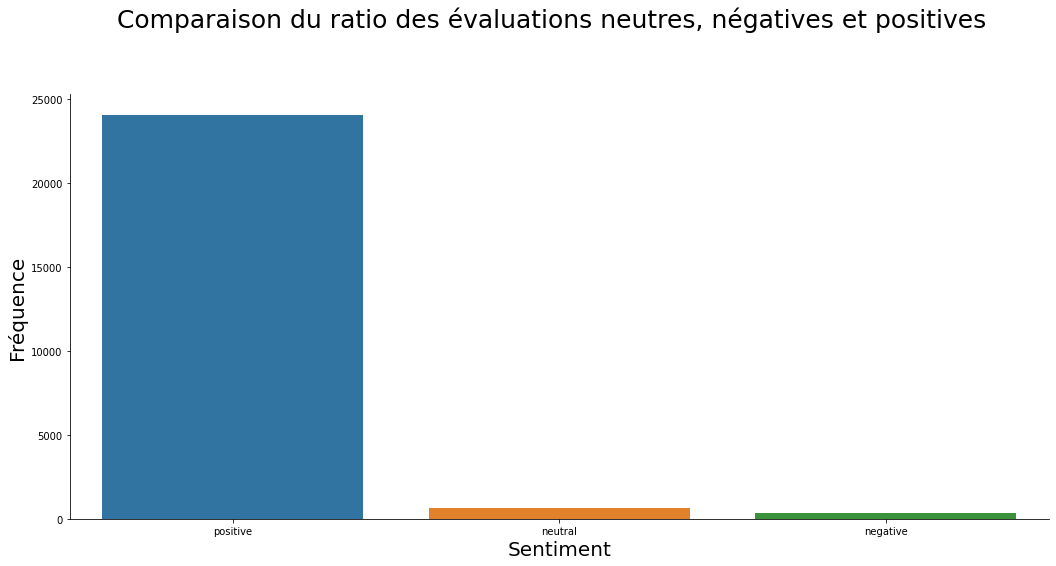

In [15]:
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparaison du ratio des évaluations neutres, négatives et positives", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Fréquence", fontsize = 20)
sns.despine()

Les évaluation sont majoritairements positives, le jeu de données est déséquilibré !

In [16]:
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Percentage de mots \"neutre\" --> {pert_count(df, 'neutral')} %")
print(f"Percentage de mots \"negatif\"  --> {pert_count(df, 'negative')} %")
print(f"Percentage de mots \"positif\" --> {pert_count(df, 'positive')} %")

Percentage de mots "neutre" --> 2.484 %
Percentage de mots "negatif"  --> 1.2919999999999998 %
Percentage de mots "positif" --> 96.224 %


### Nuage de mots

Nous définissons la fonction ci-dessous pour réaliser un nuage des mots usuels :

In [17]:
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()

Réprésentons les nuages de mots les plus usuels en fonction des avis :

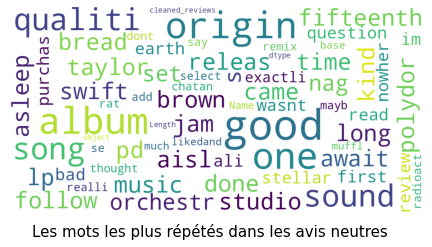

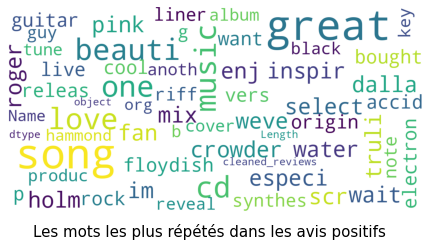

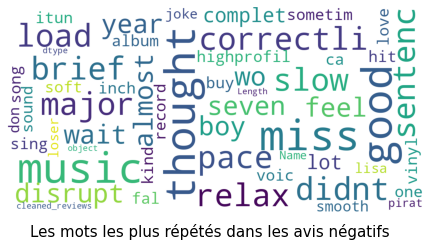

In [18]:
neu=df[df["classes"] == "neutral"]["cleaned_reviews"]
neg=df[df["classes"] == "negative"]["cleaned_reviews"]
pos=df[df["classes"] == "positive"]["cleaned_reviews"]
word_cloud(neu, "Les mots les plus répétés dans les avis neutres")
word_cloud(pos, "Les mots les plus répétés dans les avis positifs")
word_cloud(neg, "Les mots les plus répétés dans les avis négatifs")

### Expressions les plus fréquentes dans le jeu de données

Nous présentons des bigrammes en fonction des avis.

In [19]:
#création des bigrammes
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#tracés des bigrammes
def n_gram_plot(data,title,color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('Commentaire {} (Bigramme)'.format(title),fontsize=10)
    plt.yticks(rotation=0,fontsize=15)

/home/lasme/Bureau/python_programming/envs/nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lasme/Bureau/python_programming/envs/nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lasme/Bureau/python_programming/envs/nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

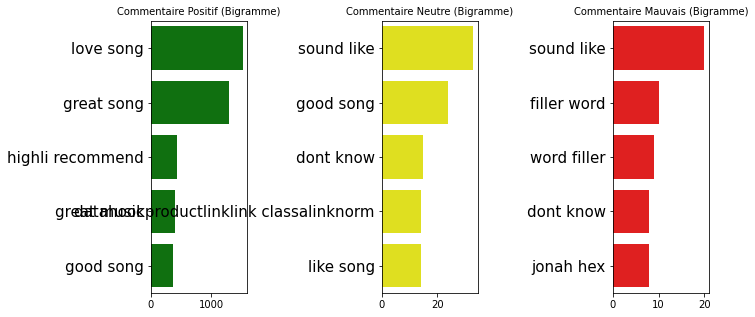

In [20]:
common_words_good = get_top_n_bigram(pos, 5)
common_words_neutral= get_top_n_bigram(neu, 5)
common_words_bad= get_top_n_bigram(neg, 5)

plt.figure(figsize=(10,5))

#top 5 bigrammes des avis positifs
plt.subplot(151)
n_gram_plot(common_words_good,'Positif','green')
#============================================= 
#top 5 bigrammes des avis neutres
plt.subplot(153)
n_gram_plot(common_words_neutral,'Neutre','yellow')
#============================================= 
#top 5 bigrammes des avis négatifs
plt.subplot(155)
n_gram_plot(common_words_bad,'Mauvais','red')
plt.show()

On peut voir que les commentaires postifs et négatifs sont très proches.

## Sentiment analysis

In [21]:
torch.cuda.is_available()

True

In [22]:
import torch
# Progress bar library
from tqdm.notebook import tqdm
# Tokenizer for bert
from transformers import BertTokenizer
# The dataset off which the model will be trained
from torch.utils.data import TensorDataset
# Model
from transformers import BertForSequenceClassification

In [23]:
df['cleaned_reviews'].isna().sum()

0

In [24]:
df.head()

,overall,reviewTime,reviewText,summary,y,cleaned_reviews,classes
0,4.0,"01 24, 2008",im not a fan of all of crowders music but ther...,Fun song,2,im fan crowder music select one one especi enj...,positive
1,5.0,"05 12, 2018",beautiful mix of the song,Five Stars,2,beauti mix song,positive
2,5.0,"06 24, 2013",love dallas holm his songs are truly inspiring...,Love it! Fast service!! Thank U!!,2,love dalla holm song truli inspir cd great scr...,positive
3,4.0,"07 20, 2017",this is the roger waters cd weve all been wait...,Great production.,2,roger water cd weve wait pink floydish great p...,positive
4,5.0,"06 20, 2014",i wanted the original release of this song but...,Review:,2,want origin releas song accid bought live vers...,positive


In [25]:
df['y'].value_counts()

2    24056
1      621
0      323
Name: y, dtype: int64

In [26]:


# Creating a dictionary which contains all unique attributes in y, here these are the classes
possible_labels = df.y.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(possible_label)
label_dict



{2: 2, 1: 1, 0: 0}

In [27]:
# Changing column name from y to label for clarity
df['label'] = [label_dict[str_label] for str_label in df['y']]

In [28]:
# Splitting the dataset into a 85-15 train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

# creating a column data_type to denote whether each record is for test or train
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['y', 'label', 'data_type']).count()

overall  reviewTime  reviewText  summary  cleaned_reviews  \
y label data_type                                                              
0 0     train          274         274         274      273              274   
        val             49          49          49       49               49   
1 1     train          528         528         528      528              528   
        val             93          93          93       93               93   
2 2     train        20448       20448       20448    20440            20448   
        val           3608        3608        3608     3607             3608   

                   classes  
y label data_type           
0 0     train          274  
        val             49  
1 1     train          528  
        val             93  
2 2     train        20448  
        val           3608

In [29]:
# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)              
# Encoding training batch                           
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
# Encoding validation batch                           
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

# Extracting variables from encoded objects for ease of use
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

# creating tensors
labels_val = torch.tensor(df[df.data_type=='val'].label.values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/lasme/Bureau/python_programming/envs/nlp/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
# Initializing the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [31]:
# Import and initialization of dataloaders and batch size hyperparameter
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [32]:
# Importing the adam optimizer and a scheduler to manage learning rate in an optimal fashion
from transformers import AdamW, get_linear_schedule_with_warmup

# Initializing the optimizer (uses the adam algorithm - an extension to stochastic gradient descent)
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
# Setting epoch hyperparameter
epochs = 3

# Scheduler to increase learning rate for a certain number of steps then linearly deacrese the same
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/home/lasme/Bureau/python_programming/envs/nlp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Defining functions for f1 score and accuracy
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct=0
    total=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        correct+=len(y_preds[y_preds==label])
        total+=len(y_true)
    print(f'Bert Model Accuracy Overall :',correct/total)

In [34]:
#to check GPU vs CPU - based on whether the local/hosted runtime has an nvidia GPU available or not
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
model.to(device)
print(device)

cpu


In [35]:
import random

# Sets torchs seed to randomize to enable usage of torch.random()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Evaluate function to be used along with tqdm to display the live progress of the model training, calculates average loss, predictions and true values.
def evaluate(dataloader_val):

    # used to turn off layers that dont perform as expected
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  
# Train the model
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
      
    # Write results  
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    #Save the finetuned model per epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/bertmodel{epoch}.model')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/665 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Display final accuracy per class
accuracy_per_class(predictions, true_vals)

In [11]:
# Let's balance it by gettign as many positives as there are negatives
df_positives = df[df.y == 2]
df_negatives = df[df.y == 1].sample(df_positives.shape[0], random_state = 1,  replace = True)
df_neutral = df[df.y == 0].sample(df_positives.shape[0], random_state = 1, replace = True)

df_balanced = pd.concat([df_negatives, df_positives, df_neutral])

<AxesSubplot:>

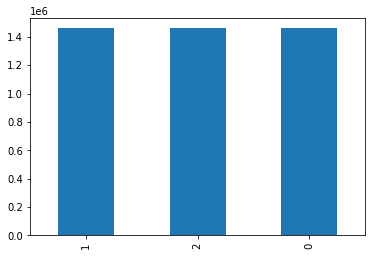

In [16]:
df_balanced["y"].value_counts().plot(kind = "bar")

## Texts Generation